![](http://nci.org.au/wp-content/themes/nci/img/img-logo-large.png)

-------

# Using GSKY's WCS in Python
### Requesting data subsets through NCI's GSKY Data Server 
NCI's GSKY Data Server supports the Open Geospatial Consortium (OGC) Web Coverage Service (WCS), which is a standard protocol for serving geospatial data in common formats such as NetCDF and GeoTIFF.  

### The following libraries will need to be imported for the below example. 

In [1]:
from owslib.wcs import WebCoverageService
from PIL import Image
%matplotlib inline

### To start, we will need the base GSKY server URL:

In [2]:
gsky_url = 'http://130.56.242.16/ows/dea/cloud_masking_agg?service=WCS&version=1.0.0&request=GetCapabilities'

### Now using OWSLib, you can begin by inspecting the service metadata:


In [3]:
wcs = WebCoverageService(gsky_url, version='1.0.0')

#### Find out the available data layers that can be requested:

In [4]:
for layer in list(wcs.contents):
    print "Layer Name:", layer
    print "Title:", wcs[layer].title, '\n'

Layer Name: LS8:NBART:TRUE
Title: DEA Landsat 8 terrain corrected surface reflectance true colour 

Layer Name: LS8:MASK:NBART:TRUE
Title: DEA Landsat 8 terrain corrected surface reflectance true colour (Cloud Masking) 

Layer Name: LS8:MASK:AGG:NBART:TRUE
Title: DEA Lansat 8 terrain corrected surface reflectance true colour (Cloud Removal) 



#### We can also view metadata that is available about a selected layer. For example, you can view the abstract associated with that data layer. 

In [5]:
layer = "LS8:MASK:NBART:TRUE"

In [6]:
print(wcs[layer].abstract)

This product has been corrected to remove the influences of the atmosphere, the time of year, terrain shadow and satellite view angles using the methods described in Li et al. 2012 https://doi.org/10.1016/j.rse.2012.06.018. Landsat 8 Operational Land Imager (OLI) data is available from March 2013 and onwards. More detailed information about the terrain corrected surface reflectance product suite produced using Digital Earth Australia including CCBY4.0 is available at http://dx.doi.org/10.4225/25/5a7a76d2e129e. This service provides access to Landsat 8 OLI terrain corrected surface reflectance data. The true colour composite is composed of wavelengths of light as seen by the human eye. The image composites are made from images acquired within a 16 day period, and may include clouds.


#### Or view the CRS options, bounding box, and time positions available (these details will be needed to construct the GetMap request). 

In [7]:
print "CRS Options: "
crs = wcs[layer].supportedCRS
print '\t', crs, '\n'
    
print "Bounding Box: "
bbox = wcs[layer].boundingBoxWGS84
print '\t', bbox, '\n'
    
print "Time Positions: "
time = wcs[layer].timepositions
print '\t', time[:10], '\n'

CRS Options: 
	[urn:ogc:def:crs:EPSG::4326] 

Bounding Box: 
	(-180.0, -90.0, 180.0, 90.0) 

Time Positions: 
	['2013-03-01T00:00:00.000Z', '2013-03-17T00:00:00.000Z', '2013-04-02T00:00:00.000Z', '2013-04-18T00:00:00.000Z', '2013-05-04T00:00:00.000Z', '2013-05-20T00:00:00.000Z', '2013-06-05T00:00:00.000Z', '2013-06-21T00:00:00.000Z', '2013-07-07T00:00:00.000Z', '2013-07-23T00:00:00.000Z'] 



### Now let's use the information above to construct and make GetCoverage requests
The below sections will demonstrate both a request in GeoTIFF and NetCDF formats.

#### We'll need to define a bounding box for our request:

In [8]:
subset_bbox = (137, -37, 142, -34)

#### OWSLib's library can now be used to make the GetCoverage request:

In [9]:
output = wcs.getCoverage(identifier=layer, 
                         time=[wcs[layer].timepositions[6]],
                         bbox=subset_bbox,format='GeoTIFF',
                         crs='EPSG:4326', width=256, height=256)

#### To view the above constructed URL:

In [10]:
print(output.geturl())

http://130.56.242.16/ows/dea/cloud_masking_agg?crs=EPSG%3A4326&service=WCS&format=GeoTIFF&request=GetCoverage&height=256&width=256&version=1.0.0&BBox=137%2C-37%2C142%2C-34&Coverage=LS8%3AMASK%3ANBART%3ATRUE&time=2013-06-05T00%3A00%3A00.000Z


#### Write the result to a file:

In [11]:
filename = './output/gsky_wcs.tiff'
with open(filename, 'wb') as f:
    f.write(output.read())

#### And if we'd like to confirm the result, we can open and view the GeoTIFF with the Python GDAL library for example:

In [12]:
import gdal
import matplotlib.pyplot as plt 
%matplotlib inline

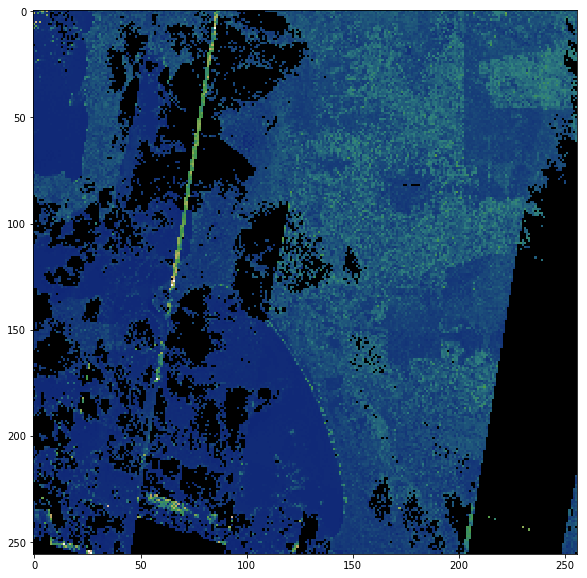

In [13]:
ds = gdal.Open(filename)
band = ds.GetRasterBand(1).ReadAsArray()

fig = plt.figure(figsize=(10,10))
plt.imshow(band, cmap='gist_earth')

#### To request a coverage returned as in the NetCDF format, a similar GetCoverage request is constructed with the format parameter now specifying the NetCDF option. 

In [14]:
output = wcs.getCoverage(identifier=layer, 
                         time=[wcs[layer].timepositions[6]],
                         bbox=subset_bbox,format='NetCDF',
                         crs='EPSG:4326', width=256, height=256)

In [15]:
print(output.geturl())

http://130.56.242.16/ows/dea/cloud_masking_agg?crs=EPSG%3A4326&service=WCS&format=NetCDF&request=GetCoverage&height=256&width=256&version=1.0.0&BBox=137%2C-37%2C142%2C-34&Coverage=LS8%3AMASK%3ANBART%3ATRUE&time=2013-06-05T00%3A00%3A00.000Z


#### Again, write the output to a file to save:

In [16]:
filename = './output/gsky_wcs.nc'
with open(filename, 'wb') as f:
    f.write(output.read())

#### To confirm or inspect the contents of the NetCDF file, libraries such as NetCDF4 Python or GDAL can be used. 

In [17]:
from netCDF4 import Dataset
import numpy as np

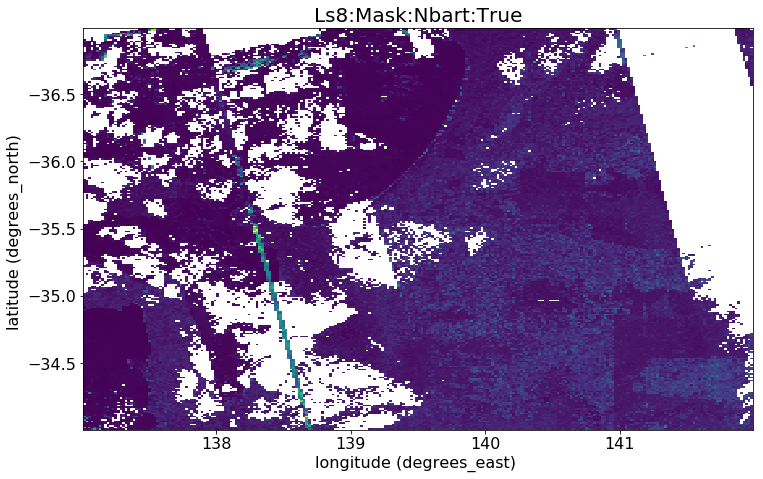

In [18]:
with Dataset(filename) as ds:
    
    band = ds['Band1']
    lon = ds['lon']
    lat = ds['lat']


    # Set figure size
    plt.figure(figsize=(12,12))

    # Plot image
    plt.imshow(band, extent=[lon[0], lon[-1], lat[-1], lat[0]])

    # Add figure title and labels
    # We can make use of the defined variable attributes to do this
    plt.title(layer.title(), fontsize=20)
    plt.xlabel(lon.long_name+' ('+lon.units+') ', fontsize=16)
    plt.ylabel(lat.long_name+' ('+lat.units+') ', fontsize=16)


    # Adjust tick mark size
    plt.tick_params(labelsize=16)

<br>
<br>
<br>


--------
**For more information on the OGC WCS standard specifications and the Python OWSLib package:** <br/>
http://www.opengeospatial.org/standards/wcs <br/>
https://geopython.github.io/OWSLib/#wms <br/>
